Using device: cuda


c:\Users\eel20\Desktop\Syphilis\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
c:\Users\eel20\Desktop\Syphilis\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/150
Train Loss: 2.0502 Acc: 0.1501
Val Loss: 1.8900 Acc: 0.1983

Epoch 2/150
Train Loss: 1.9158 Acc: 0.2093
Val Loss: 1.7836 Acc: 0.2601

Epoch 3/150
Train Loss: 1.7861 Acc: 0.2930
Val Loss: 1.6943 Acc: 0.3052

Epoch 4/150
Train Loss: 1.6955 Acc: 0.3297
Val Loss: 1.6882 Acc: 0.3230

Epoch 5/150
Train Loss: 1.6427 Acc: 0.3642
Val Loss: 1.6814 Acc: 0.3432

Epoch 6/150
Train Loss: 1.5800 Acc: 0.3960
Val Loss: 1.7256 Acc: 0.3171

Epoch 7/150
Train Loss: 1.5363 Acc: 0.4180
Val Loss: 1.6144 Acc: 0.3515

Epoch 8/150
Train Loss: 1.5011 Acc: 0.4288
Val Loss: 1.4817 Acc: 0.4192

Epoch 9/150
Train Loss: 1.4675 Acc: 0.4398
Val Loss: 1.6216 Acc: 0.3420

Epoch 10/150
Train Loss: 1.4287 Acc: 0.4782
Val Loss: 1.6041 Acc: 0.4038

Epoch 11/150
Train Loss: 1.4190 Acc: 0.4731
Val Loss: 1.5663 Acc: 0.3979

Epoch 12/150
Train Loss: 1.3621 Acc: 0.4967
Val Loss: 1.4112 Acc: 0.4834

Epoch 13/150
Train Loss: 1.3279 Acc: 0.5118
Val Loss: 1.4011 Acc: 0.4727

Epoch 14/150
Train Loss: 1.3211 Acc: 0.5202
Val

C:\Users\eel20\AppData\Local\Temp\ipykernel_29248\706985259.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


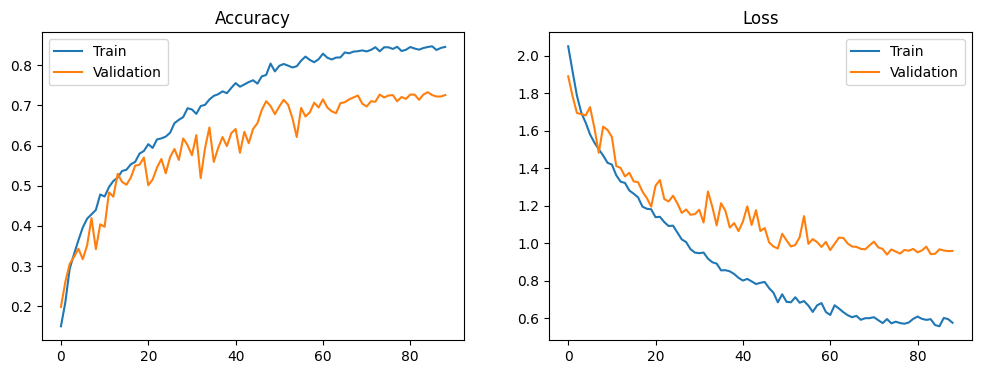

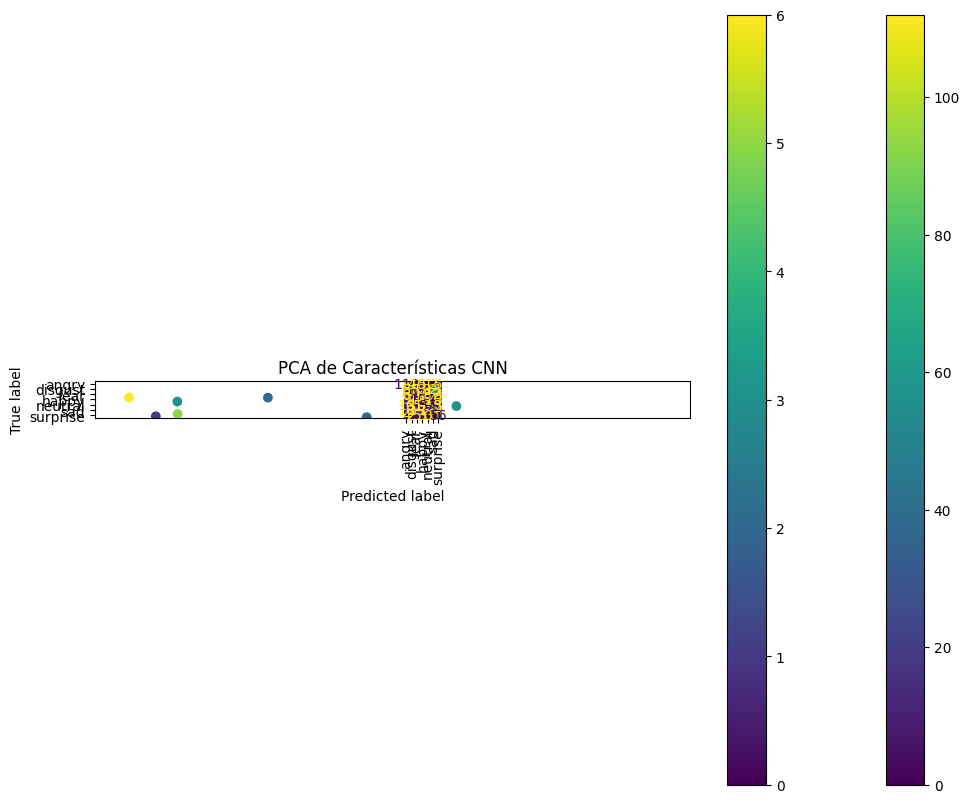

In [6]:
import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def load_data(dataset_path, img_size=(128, 128)):
    """Carga espectrogramas y etiquetas desde el directorio"""
    X = []
    y = []
    class_names = sorted(os.listdir(dataset_path))
    
    for label in class_names:
        class_path = os.path.join(dataset_path, label)
        files = glob.glob(os.path.join(class_path, '*.png'))
        
        for file in files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y)
    return X, y, class_names

def augment_data(X, y, augmentation_factor=0.5):
    aug_X = []
    aug_y = []
    
    for i in range(len(X)):
        # Original
        aug_X.append(X[i])
        aug_y.append(y[i])
        
        # Aumentaciones probabilísticas
        if np.random.rand() < augmentation_factor:
            # Time warping
            warp_factor = np.random.uniform(0.8, 1.2)
            warped = cv2.resize(X[i], (int(X[i].shape[1]*warp_factor), X[i].shape[0]))
            warped = cv2.resize(warped, (X[i].shape[1], X[i].shape[0]))
            aug_X.append(warped)
            aug_y.append(y[i])
            
        if np.random.rand() < augmentation_factor:
            # Mixup
            j = np.random.randint(0, len(X))
            alpha = np.random.beta(0.4, 0.4)
            mixed = alpha*X[i] + (1-alpha)*X[j]
            aug_X.append(mixed)
            aug_y.append(y[i])
            
        if np.random.rand() < augmentation_factor:
            # Gaussian noise
            noise = np.random.normal(0, 0.05, X[i].shape)
            noisy = np.clip(X[i] + noise, 0, 1)
            aug_X.append(noisy)
            aug_y.append(y[i])
    
    return np.array(aug_X), np.array(aug_y)

def preprocess_labels(y):
    """Codificación de etiquetas"""
    le = LabelEncoder()
    return le.fit_transform(y), le


class HybridModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        # Capas CNN con mayor regularización
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5)
        )
        
        # LSTM simplificado
        self.lstm = nn.LSTM(
            input_size=16*16,
            hidden_size=128,
            num_layers=1,
            bidirectional=False,
            dropout=0.3,
            batch_first=False
        )
        
        # Capas densas con mayor regularización
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # CNN
        x = self.conv_layers(x)
        
        # Reestructurar
        batch_size = x.size(0)
        x = x.view(batch_size, 128, -1).permute(1, 0, 2)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[-1]
        
        # Clasificación
        return self.fc_layers(x)
    
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return loss.mean()

# Reemplaza el criterion
criterion = FocalLoss(alpha=0.25, gamma=2.0).to(device)

def main():
    # Configuración
    dataset_path = 'Ravdess_mel_specs'
    img_size = (128, 128)
    test_size = 0.15
    val_size = 0.15
    batch_size = 32
    max_epochs = 150
    
    # Cargar y preprocesar datos
    X, y, class_names = load_data(dataset_path, img_size)
    X_aug, y_aug = augment_data(X, y)
    y_encoded, le = preprocess_labels(y_aug)
    num_classes = len(class_names)
    
    # Dividir datos
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_aug, y_encoded, test_size=test_size, stratify=y_encoded
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp
    )

    # Convertir a tensores ANTES de crear el sampler
    X_train = torch.FloatTensor(X_train).unsqueeze(1).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_val = torch.FloatTensor(X_val).unsqueeze(1).to(device)
    y_val = torch.LongTensor(y_val).to(device)
    X_test = torch.FloatTensor(X_test).unsqueeze(1).to(device)
    y_test = torch.LongTensor(y_test).to(device)

    # Calcular pesos SOLO con los datos de entrenamiento
    class_counts = np.bincount(y_train.cpu().numpy())
    class_weights = 1. / class_counts
    samples_weights = class_weights[y_train.cpu().numpy()]

    # Crear sampler
    from torch.utils.data import WeightedRandomSampler
    sampler = WeightedRandomSampler(
        weights=samples_weights,
        num_samples=len(y_train),
        replacement=True
    )

    # Crear DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=sampler,
        drop_last=True
    )
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Inicializar modelo
    model = HybridModel((1, *img_size), num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    # Reemplaza en main()
    # Optimizador con mayor regularización
    optimizer = optim.AdamW(model.parameters(), 
                          lr=0.0005,  # Reducir learning rate
                          weight_decay=0.05)  # Aumentar weight decay
    # Scheduler más conservador
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5, 
        verbose=True
    )

    # Entrenamiento
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(max_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Añadir esto
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Validación
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Calcular métricas
        train_loss = train_loss / total
        train_acc = correct / total
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Actualizar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Actualizar scheduler y early stopping
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        print(f'Epoch {epoch+1}/{max_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')
    
    # Evaluación final
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(f'Test Loss: {test_loss/test_total:.4f}')
    print(f'Test Accuracy: {test_correct/test_total:.4f}')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Gráficas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()

    from sklearn.metrics import ConfusionMatrixDisplay

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12,10))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.savefig('confusion_matrix.png')


    from torchvision.utils import make_grid
    # Obtener embeddings de la última capa CNN
    with torch.no_grad():
        features = model.conv_layers(X_test[:64])
        features = features.view(features.size(0), -1).cpu().numpy()

    # Visualización con PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(features)
    plt.scatter(embeddings[:,0], embeddings[:,1], c=y_test[:64].cpu())
    plt.colorbar()
    plt.title('PCA de Características CNN')

if __name__ == '__main__':
    main()